# This notebook helps you go through the entire project. It mainly has three parts. 
## First is to test the mapping function with 'test_ranges' lidar data. 
## Second is the primary part of SLAM, namely simultaneous localization and mapping. 
## The last part is texture mapping.
## You can simpy start by clicking on Restart & Run All

by changing the variable dataset, you can switch between diffent datasets to see the results

Import the packages and modules for this project

In [1]:
# import online packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# import modules created for this project
import load_data
import mapping
import map_utils
import prediction
import update
import texture

# select dataset to use
dataset=23

Load all data

In [2]:
# load data from different sensors
with np.load("Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps
with np.load("Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans
with np.load("Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # Accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements
if dataset!=23:
    with np.load("Kinect%d.npz"%dataset) as data:
        disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
        rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

# load the trajectory based on the best particle at each timestamp
# muBestTimestamp=np.load('muBestTimestamp.npy')

'with np.load("Kinect%d.npz"%dataset) as data:\n    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images\n    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images'

First mapping with test ranges

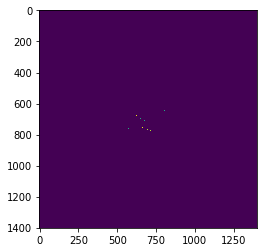

In [3]:
# mapping from the first laser scan and plot the map
m=mapping.initMap()
ranges=np.load("test_ranges.npy")

# define measurement trust
trust_1,trust_0=4,1/4

# initialize map, transform from Lidar frame to world frame
# convert from meters to occupancy grid cells
# for keeping track of cell logodds
    
Y=mapping.Lidar_wTbbTl(ranges)
sx,sy,xis,yis=mapping.formCells(Y,0.29833,0)

# pass scan in world frame to bresenham2D and update cell logodds
for i in range(len(Y)):
    ex=xis[i]
    ey=yis[i]
    location_occupied=map_utils.bresenham2D(sx, sy, ex, ey)
    index_x=location_occupied[0].astype('int64')
    index_y=location_occupied[1].astype('int64')
    #m[index_x[:-1],index_y[:-1]]=m[index_x[:-1],index_y[:-1]]+np.log(trust_0)
    m[index_x[-1],index_y[-1]]=m[index_x[-1],index_y[-1]]+np.log(trust_1)

# show updated map
#m[m>=0]=1
#m[m<0]=0
m=1-1/(1+np.exp(m))
plt.imshow(m)

Localization Prediction, Update and Mapping

In [4]:
# We assume that the inital robot state is at the origin
# of the world frame and the robot frame aligned with world frame
initPose=np.array([0,0,0])
# So let's initialize with 100 particles at the origin of world frame
# and assign them with equal weights
N=1
mu=np.zeros((3,N)) # particle positions
# muBestTimestamp=np.zeros((3,len(encoder_stamps)-1))
alpha=np.ones((N))/N

# initialize a 2D Gaussian noise for adding to control inputs
mean=[0,0]
cov=[[10**(-6),0],[0,10**(-7)]]

# use a numpy array to store the pose at different encoder_stamps
pose=np.zeros((len(encoder_stamps)-1,3))

# current map and physical positions that I want to evaluate correlation 
im_trajectory=mapping.initMap()
im_mapping=mapping.initMap()
x_range = np.arange(-0.2,0.2+0.05,0.05)
y_range = np.arange(-0.2,0.2+0.05,0.05)

# initialize a map for creating gif
mMap,nMap=im_mapping.shape
img_mapping_gif=np.zeros((mMap,nMap,3))

# define measurement trust
trust_1,trust_0=4,1/4

# create a frames list to store all frames created
imgFrames=[]

# make predictions of robot pose and append to trajectory array
# using the particle with the largest weight
for i in range(len(encoder_stamps)-1):
    
    ## PREDICTION STEP
    # parse the control inputs and add with noise
    # predict new poses for all particles
    noise=np.random.multivariate_normal(mean,cov,N) # Nx2 array
    controlTimesT=prediction.parseControl(i,encoder_stamps,encoder_counts,imu_stamps,imu_angular_velocity)
    controlTimesT=controlTimesT+noise # Nx2 array
    mu=prediction.diff_drive(mu,controlTimesT)
    
    ## UPDATE STEP
    # To use particles updated and resampled for each timestamp
    x_im,y_im,xw0,yw0,yaw_W,len_valid=update.parseScan(i,mu,lidar_stamps,lidar_ranges,encoder_stamps)
    
    # start update the weights of particles
    max_corr=np.zeros((N))
    for j in range(N):
        #corr=np.zeros((9))
        #for k in range(9): # add 9 different variations to yaw
            #yaw_W[j]=yaw_W[j]+np.random.normal(0,0.1)
        yaw_vari=np.ones((len_valid))*yaw_W[j]
            #vp=np.stack((xw0[j],yw0[j],yaw_vari))
        vp=np.stack((xw0[j],yw0[j],yaw_vari))
            # use laser correlation model to get a correlation
            # between transformed scan and grid
            #corr[k]=np.max(map_utils.mapCorrelation(im, x_im, y_im, vp, x_range, y_range))
        im=np.zeros_like(im_mapping)
        im[:]=im_mapping[:]
        im[im>=0]=1
        im[im<0]=0
        max_corr[j]=np.max(map_utils.mapCorrelation(im, x_im, y_im, vp, x_range, y_range))
    
    # get the new weights
    alpha=alpha*np.exp(max_corr-np.max(max_corr))
    alpha=alpha/np.sum(alpha)
    
    # stratified resampling
    Neff=1/np.sum(alpha**2)
    Nthres=N/2
    if Neff<=Nthres:
        k=0
        c=alpha[0]
        for j in range(N):
            u=np.random.uniform(0,1/N)
            beta=u+j/N
            while beta>c:
                k=k+1
                c=c+alpha[k]
            mu[:,j]=mu[:,k]
    alpha=np.ones((N))/N
            
    # pick the particle with highest alpha 
    # for creating trajectory and mapping
    muIndex=np.argmax(alpha)
    pose[i,:]=mu[:,muIndex]
    # muBestTimestamp[:,i]=mu[:,muIndex] # store the best particle at each timestamp

    ## MAPPING STEP
    # convert from meters to occupancy grid cells
    # for keeping track of cell logodds
    Y=np.stack((xw0[muIndex],yw0[muIndex]),axis=-1)
    sx,sy,xis,yis=mapping.formCells(Y,mu[0,muIndex],mu[1,muIndex])

    # pass scan in world frame to bresenham2D and update cell logodds
    for t in range(len(Y)):
        ex=xis[t]
        ey=yis[t]
        location_occupied=map_utils.bresenham2D(sx, sy, ex, ey)
        index_x=location_occupied[0].astype('int64')
        index_y=location_occupied[1].astype('int64')
        im_mapping[index_x[:-1],index_y[:-1]]=im_mapping[index_x[:-1],index_y[:-1]]+np.log(trust_0)
        im_mapping[index_x[-1],index_y[-1]]=im_mapping[index_x[-1],index_y[-1]]+np.log(trust_1)
        
    # create frames for making a GIF to show explicitly simultaneous localization and mapping
    # color the map for occupied, unoccupied and undefined regions
    if i%50==0:
        maskOccu=im_mapping>0
        maskUnoccu=im_mapping<0
        maskUndefined=im_mapping==0
        
        img_mapping_gif[maskOccu]=0   # black for occupied
        img_mapping_gif[maskUnoccu]=255   # white for unoccupied
        img_mapping_gif[maskUndefined]=128   # gray for undefined
        # color the trajectory
        sx,sy,xis,yis=mapping.formCells(pose[i:i+1,:2],0,0)
        img_mapping_gif[xis[0]-3:xis[0]+3,yis[0]-3:yis[0]+3]=[255,0,0]   # red for trajectory
        
        # Rotate the image counter-clockwise by 90 degrees
        im_mapping_gif_rot=np.array(list(zip(*img_mapping_gif))[::-1])
        imgFrames.append(im_mapping_gif_rot)
        # record the process
        print(i)

# remove yaw data from pose and create a trajectory [xis,yis]
sx,sy,xis,yis=mapping.formCells(pose[:,:2],0,0)
# x_max,y_max=np.amax(trajectory,axis=0)[0],np.amax(trajectory,axis=0)[1]

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800


Visualize trajectory

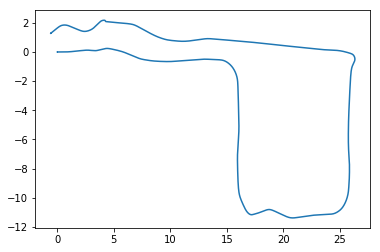

In [6]:
# visualize trajectory in physical dimensions
plt.plot(pose[:,0],pose[:,1])

Visualize map

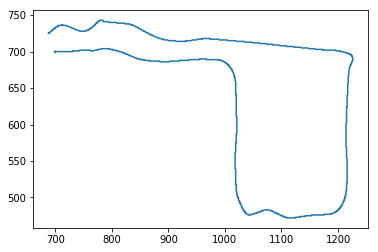

In [7]:
# visualize trajectory in grid cell positions
plt.plot(xis,yis)

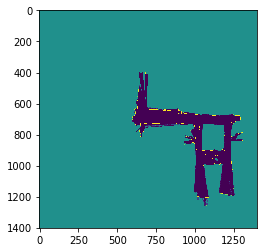

In [8]:
# visualize map
# im_mapping[im_mapping>=0]=1
# im_mapping[im_mapping<0]=0
im_mapping=1-1/(1+np.exp(im_mapping))
# Rotate the image counter-clockwise by 90 degrees
im_mapping=np.array(list(zip(*im_mapping))[::-1])
plt.imshow(im_mapping)

Plot trajectory and map in one image

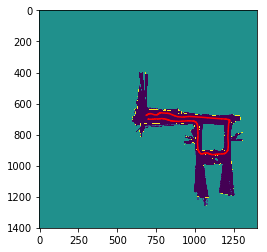

In [13]:
# plot in one image
plt.figure()
plt.imshow(im_mapping)
plt.plot(xis,1401-yis,'r-',)
plt.show()

Create a gif

In [10]:
# make a gif showing SLAM
# trajSeq=0
fig,ax=plt.subplots()
def update(whichFrame):
    # ax.plot(xis[trajSeq],1201-yis[trajSeq],'ro',markersize=2)
    ax.imshow(imgFrames[whichFrame].astype(np.int))
    # trajSeq=trajSeq+50
anim=FuncAnimation(fig,update,frames=len(imgFrames),interval=200,repeat=True)
anim.save('SLAM_Zi_He.gif')
plt.close()

MovieWriter ffmpeg unavailable.


Texture mapping

In [11]:
# initialize a map for texture mapping
im_texture_mapping=texture.initMap()

# update the texture map sequentially according to the timestamp of disparity images
for i in range(len(rgb_stamps)):
    # find the corresponding pose (of the best particle)
    # according to the rgb timestamp
    rgbTime=rgb_stamps[i]
    closest_index=np.argmin(np.abs(rgbTime-encoder_stamps[:-1]))
    muBest=pose[closest_index,:]
    # find corresponding cell positions in grid 
    # and pixel positions in RGB image
    cellCoordi,rgbi,rgbj=texture.parseKinect(i,dataset,muBest,disp_stamps,rgb_stamps,encoder_stamps)
    # color the cells using points from RGB image
    im_texture_mapping=texture.colorCells(i,dataset,im_texture_mapping,cellCoordi[0],cellCoordi[1],rgbi,rgbj)
    
# plot the texture map
plt.imshow(im_texture_mapping)

NameError: name 'rgb_stamps' is not defined

In [14]:
from scipy import signal
b, a = signal.butter(1,0.02,'lowpass')
imu_angular_velocity1 = signal.filtfilt(b, a, imu_angular_velocity)

In [15]:
imu_angular_velocity1

array([[-0.01084761, -0.01001556, -0.00920837, ..., -0.01197907,
        -0.01278494, -0.01358861],
       [-0.00437827, -0.00380094, -0.0032304 , ...,  0.00742729,
         0.00761801,  0.0078132 ],
       [-0.0116056 , -0.01093566, -0.01027328, ...,  0.00457201,
         0.00463078,  0.00469152]])

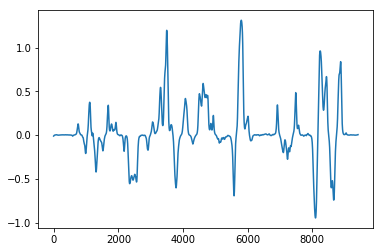

In [16]:
plt.plot(imu_angular_velocity1[2,:])

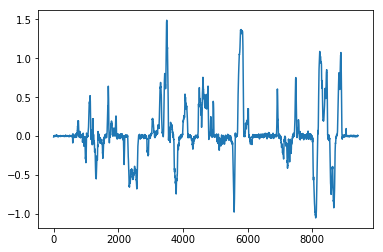

In [17]:
plt.plot(imu_angular_velocity[2,:])